In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem

# Discovering Materials for Organic Photovoltaics

In this notebook, we'll look at a [dataset of experimental power conversion efficiencies](https://doi.org/10.1021/acs.jpclett.1c03526) obtained for polymer organic photovoltaic (OPV) cells. In these solar cells, the active phase consists of a mix between a polymer donor (p-type) and a molecular acceptor (n-type) material. These form a so called bulk heterojunction that allows charges to separate when light is absorbed. This dataset specifically focuses on non-fullerene acceptor materials (NFAs).

## The Dataset

Our goal will be to build a representation of the p- and n-type components and predict the power efficiency. This will allow the prediction of new promising material combinations. First we load the data:

In [2]:
opv_df = pd.read_csv('data/opv.txt',sep='\t')

To get an idea what the dataset contains, we can print the pandas dataframe, which gives a nice overview.

In [161]:
print(opv_df)

        ID  Ref  PCE_max(%)  PCE_ave(%)  Jsc(mA/cm2)     FF  Voc(V)  \
0        1    1        6.93        6.86        16.35  0.500   0.865   
1        2    1        3.09        2.98        10.31  0.380   0.794   
2        3    2        8.33        8.12        15.28  0.690   0.790   
3        4    3        8.67        8.35        14.00  0.579   1.070   
4        5    4        8.46        8.33        13.95  0.601   1.010   
...    ...  ...         ...         ...          ...    ...     ...   
1313  1314  557       13.19       13.09        18.62  0.738   0.960   
1314  1315  558        2.15        2.08         6.59  0.410   0.770   
1315  1316  558       10.10        9.78        16.26  0.650   0.930   
1316  1317  558        3.97        3.67         7.81  0.510   0.950   
1317  1318  558        2.34        2.24         5.80  0.380   0.970   

      '-HOMO_n(eV)  '-LUMO_n(eV)  Eg_n(eV)  \
0             5.67          3.89      1.76   
1             5.68          3.92      1.76   
2        

As you can see, the dataset contains a number of solar cell characteristics, like the power conversion efficiency (PCE), the short-circuit current (Jsc) and the open-circuit voltage (Voc). Furthermore, the donor and acceptor materials are encoded as SMILES strings, along with the HOMO, LUMO and band gap energies. Our goal will be to predict the PCE of a given material combination.

Next we need to convert the donor and acceptor SMILES strings into machine readable representations. To this end we'll use [Morgan Fingerprints](https://pubs.acs.org/doi/10.1021/ci100050t), which can be obtained from [RDkit](https://www.rdkit.org/). We'll use the common variant of 1024 bits and radius 2. In principle, tuning these may improve the performance of the model. For further processing we first generate lists with the fingerprints and corresponding PCEs.

In [36]:
def SMILEStoMorganFP(smiles,radius=2, nBits=2048):
    molecule = AllChem.MolFromSmiles(smiles)
    #print(molecule)
    try:
        feature_list = AllChem.GetMorganFingerprintAsBitVect(molecule, radius = radius, nBits = nBits)
        return list(feature_list)
    except:
        feature_list = None
        return feature_list
        #print(molecule,smiles)


In [39]:
fingerprints_n = []
fingerprints_p = []
PCEs = []
for index, row in opv_df.iterrows():
    #print(row['n(SMILES)'], row['p(SMILES)'])
    pSMILES = row['p(SMILES)']
    nSMILES = row['n(SMILES)']
    PCE = row['PCE_ave(%)']
    fp_n = SMILEStoMorganFP(nSMILES,radius=2, nBits=1024)
    fp_p = SMILEStoMorganFP(pSMILES,radius=2, nBits=1024)
    #print(fp_n)
    if (fp_n is None) or (fp_p is None):
        pass
    else:
        fingerprints_n.append(fp_n)
        fingerprints_p.append(fp_p)
        PCEs.append(PCE)
        
print(len(PCEs))

[15:04:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[15:04:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[15:04:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[15:04:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[15:04:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[15:04:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[15:04:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[15:04:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[15:04:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[15:04:36] Explicit valence for atom # 14 N, 4, is greater than permitted
[15:04:43] Explicit valence for atom # 37 N, 4, is greater than permitted
[15:04:43] Explicit valence for atom # 53 N, 4, is greater than permitted
[15:04:44] Explicit valence for atom # 47 C, 5, is greater than permitted
[15:04:44] Explicit valence for atom #

1295


This worked, although there were a few errors, where SMILES could not be converted to fingerprints. We'll ignore these cases and work with the 1295 materials combinations that went through the conversion process.

## Regression Model

Now we can build a regression model. To this end, we'll do a few more preprocessing steps. Specifically, we'll shuffle the data and concatenate the acceptor and donor fingerprints to have a single representation vector for each solar cell. Then we split the data into training, validation and test sets, using a 70/10/20 split.

In [171]:
i_train = int(0.7*1295)
i_val   = int(0.8*1295)

finger_train = []
pce_train    = []
finger_val   = []
pce_val      = []
finger_test  = []
pce_test     = []

irand = np.arange(1295)
np.random.shuffle(irand)

for idx,i in enumerate(irand):
    ftemp   = fingerprints_n[i] + fingerprints_p[i]
    pcetemp = PCEs[i]
    
    if idx < i_train:
        finger_train.append(ftemp)
        pce_train.append(pcetemp)
    elif idx < i_val:
        finger_val.append(ftemp)
        pce_val.append(pcetemp)
    else:
        finger_test.append(ftemp)
        pce_test.append(pcetemp)
        
finger_train = np.array(finger_train)
finger_val   = np.array(finger_val)
finger_test  = np.array(finger_test)
pce_train    = np.array(pce_train)
pce_val      = np.array(pce_val)
pce_test     = np.array(pce_test)

print(f"Training   set {finger_train.shape} {pce_train.shape}")
print(f"Validation set {finger_val.shape} {pce_val.shape}")
print(f"Test       set {finger_test.shape} {pce_test.shape}")
#fingerprints = np.array([fingerprints_n,fingerprints_p])
#fingerprints = np.swapaxes(fingerprints)
#print(fingerprints.shape)

Training   set (906, 2048) (906,)
Validation set (130, 2048) (130,)
Test       set (259, 2048) (259,)


Now to the model itself. We'll use the `gaussian_process` module of sklearn to fit a GPR model. GPR generally gives quite accurate models and require fairly little tuning, since the hyperparameters can be automatically optimized using the log marginal likelihood. I used the validation set to tinker around with different kernels, but found that the simple RBF kernel works quite well overall. Feel free to experiment with this yourself. Some alternative kernels are shown in the comments.

Of course, we always add a `WhiteKernel` to model the uncertainty in the data. This is very important here, since we cannot expect experimental data from different labs to be exactly comparable. Furthermore, the performance of the solar cells does not merely depend on the structure of the donors and acceptors (which is what we're giving to the model as inputs), but also on many other factors like the processing conditions, film thickness, etc. 

The model specification and fitting is just a couple of lines in sklearn:

In [172]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, RationalQuadratic

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(1e-1)
#kernel = 1 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) + WhiteKernel(1e-1)
#kernel = (1 * RationalQuadratic(length_scale=1.0, alpha=1.0, length_scale_bounds=(1e-05, 100000.0), alpha_bounds=(1e-05, 100000.0)) 
#              + WhiteKernel(1e-1))



gaussian_process = GaussianProcessRegressor(
    kernel=kernel, n_restarts_optimizer=9)
                                                                                          
gaussian_process.fit(finger_train, pce_train)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.1),
                         n_restarts_optimizer=9)

Now we can look at the optimized kernel hyperparameters. We find a noise_level of 2.81, which is pretty reasonable for this data. I can easily believe that the same materials, processed in two different labs yield solar cell efficiencies that differ by a couple of percentage points. See, for example, this [older literature survey on a common type of polymer solar cell](https://onlinelibrary.wiley.com/doi/10.1002/adma.201100792).

In [174]:
print(gaussian_process.kernel_)
print(gaussian_process.log_marginal_likelihood_value_)

#4.01**2 * RBF(length_scale=7.65) + WhiteKernel(noise_level=2.31)
#-2029.0400452990405
#MAE train/val 0.86/1.76
#RMSE train/val 1.16/2.62

#3.96**2 * Matern(length_scale=9.24, nu=1.5) + WhiteKernel(noise_level=1.64)
#-2011.9780415675568
#MAE train/val 0.64/1.74
#RMSE train/val 0.87/2.63

#10.7**2 * RationalQuadratic(alpha=0.0252, length_scale=12.5) + WhiteKernel(noise_level=1.36)
#-2003.8745335239316
#MAE train/val 0.54/1.75
#RMSE train/val 0.74/2.63


4.06**2 * RBF(length_scale=8.38) + WhiteKernel(noise_level=2.81)
-2051.95133247143


Once we've settled on a kernel, we can also perform predictions on the test set to see how well our model generalizes:

In [175]:
predict_val, val_std = gaussian_process.predict(finger_val, return_std=True)
predict_test, test_std = gaussian_process.predict(finger_test, return_std=True)
predict_train = gaussian_process.predict(finger_train, return_std=False)

MAE train/val/test 1.00/1.70/1.55
RMSE train/val/test 1.35/2.36/2.15


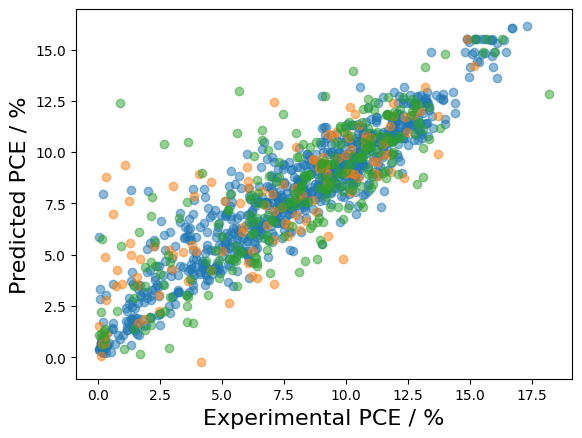

In [185]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_val = mean_absolute_error(pce_val,predict_val)
mae_train = mean_absolute_error(pce_train,predict_train)
mae_test = mean_absolute_error(pce_test,predict_test)

rmse_val = np.sqrt(mean_squared_error(pce_val,predict_val))
rmse_train = np.sqrt(mean_squared_error(pce_train,predict_train))
rmse_test = np.sqrt(mean_squared_error(pce_test,predict_test))

print(f'MAE train/val/test {mae_train:.2f}/{mae_val:.2f}/{mae_test:.2f}')
print(f'RMSE train/val/test {rmse_train:.2f}/{rmse_val:.2f}/{rmse_test:.2f}')

plt.scatter(pce_train,predict_train,alpha=0.5)
plt.scatter(pce_val,predict_val,alpha=0.5)
plt.scatter(pce_test,predict_test,alpha=0.5)

plt.xlabel('Experimental PCE / %',fontsize=16)
plt.ylabel('Predicted PCE / %',fontsize=16)

plt.show()

The model thus ends up predicting the PCEs of unknown combinations with an RMSE around 2%. Given what I wrote above, we cannot really expect much more accuracy, so further tuning this model is rather pointless. Indeed, for the purpose of materials design, this is quite ok. We can reliably differentiate between bad and good materials combinations, with some exceptions. Furthermore, the GPR model provides us with a standard deviation for each prediction. This can be useful when deciding which materials to test. If the predicted PCE of a material is low, but the uncertainty is high, it might be worth testing nonetheless. But can we trust the estimated uncertainty?

## Uncertainty Quantification

To this end, we can use the `uncertainty_toolbox` package. This allows us to calculate a number of metrics that measure the calibration of our uncertainty estimates. A useful way of doing this is via calibration curves. Briefly, this takes advantage of the fact that standard deviations have a probabilistic interpretation (assuming normally distributed errors). Specifically, for an ideally calibrated model, the true value should lie within one standard deviation of the prediction 68% of the time, within two standard distributions 95% of the time and within three standard distributions 99.7% of the time, etc. A calibration curve, allows us to visualize how often this is actually the case for different predictive intervals. In this case, the model does fairly well, although it is actually a little underconfident (i.e. the uncertainties are somewhat too large).



MACE: 0.06, RMSCE: 0.07, MA: 0.06


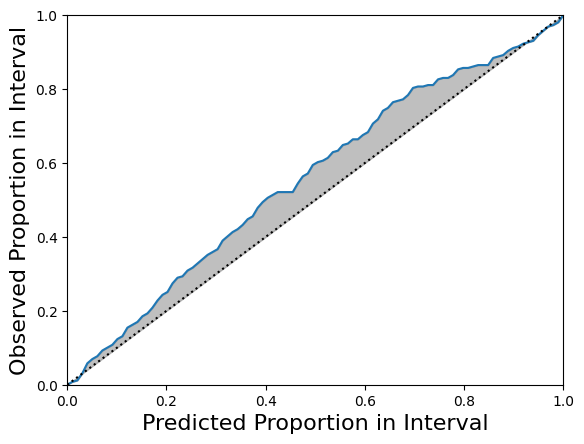

In [186]:
import uncertainty_toolbox as uct

mace = uct.mean_absolute_calibration_error(predict_test, test_std, pce_test)
rmsce = uct.root_mean_squared_calibration_error(predict_test, test_std, pce_test)
ma = uct.miscalibration_area(predict_test, test_std, pce_test)
print(f"MACE: {mace:.2f}, RMSCE: {rmsce:.2f}, MA: {ma:.2f}")

pred_inter, obs_inter = uct.get_proportion_lists_vectorized(predict_test, test_std, pce_test)

#uct.plot_calibration(predict_test, test_std, pce_test)
plt.plot(pred_inter, obs_inter)
plt.plot(pred_inter, pred_inter,c='k',linestyle=':')
plt.fill_between(pred_inter,pred_inter,obs_inter,color='grey',alpha=0.5)

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel('Predicted Proportion in Interval',fontsize=16)
plt.ylabel('Observed Proportion in Interval',fontsize=16)

plt.show()

#idx_counter += 1
        #make_plots(pred_mean, pred_std, f"row_{idx_counter}")

#print(f"MACE: {mace}, RMSCE: {rmsce}, MA: {ma}")
#print(ma)

## Active Discovery

The above model uses a typical but somewhat artificial approach to ML based materials discovery: We used a large dataset of experimental data and trained our model on 70% of it, leaving 30% for validation and testing. In reality, we often do not have so much data lying around and it would be very inefficient to run thousands of experiments before we can even begin to fit our model. Fortunately, with an uncertainty-aware model we can be much more efficient by using an *active learning* approach. To demonstarte this we first do some data preparation, using an initial training set of just four samples and a *discovery set* containing the rest of the samples:

In [148]:
# Active Discovery Data Preparation
from numpy.random import default_rng

def generate_discovery_splits(i_train_initial=4,seed=42):
    rng = default_rng(seed)
    i_train_initial = 4 #int(0.01*1295)
    #print()

    finger_train = []
    pce_train    = []
    smiles_train = []
    finger_discover   = []
    pce_discover      = []
    smiles_discover   = []

    irand = np.arange(1295)
    rng.shuffle(irand)
    #print(irand)

    for idx,i in enumerate(irand):
        ftemp   = fingerprints_n[i] + fingerprints_p[i]
        pcetemp = PCEs[i]
    
        if idx < i_train_initial:
            finger_train.append(ftemp)
            pce_train.append(pcetemp)
        else:
            finger_discover.append(ftemp)
            pce_discover.append(pcetemp)
    return finger_train, pce_train, finger_discover, pce_discover
            

The basic idea behind active discovery is that we fit our model to the initial training set and make predictions for the full discovery set. Based on this we can decide which are the most promising examples using a so called acquisition function. This function provides us with a number based on which we rank the candidates. In the simplest version, this is just the predicted efficiency. However, since our initial model will not be very accurate (due to the small training set) we can do better by using an uncertainty-aware acquisition function like the upper confidence bound (UCB):

$$
\mathrm{UCB}(i) = \mathrm{PCE}(i) + \lambda \sigma(i) 
$$

The UCB will be high for systems with a high PCE, but it will also be high if the predictive uncertainty $sigma$ is high. Additionally, there is a hyperparameter $\lambda$ which defines the weight of the uncertainty component. Empirically, we can understand this parameter as a tuning factor between a model that focuses on *exploitation* ($\lambda=0$) and one that focuses on *exploration* ($\lim_{\lambda\to\infty}$). From a statistical perspective, you can also see it as a way of being conservative in your ranking. Given the properties of the normal distribution, $\lambda=1$ does the ranking in such a way that it corrects the predicted PCE to the highest value that is within the 68% conficence interval and $\lambda=2$ assumes a 95% confidence interval. We'll use the latter below.

Once we have an acquisition function, we can build our discovery workflow. To this end, we first train our model and predict the PCE and $sigma$ values for the discovery set. Then we choose a fixed number (in this case four) of candidates based on the UCB. For these candidates, we now have to determine the true PCE, which in reality would mean running some experiments (and here just means looking them up in the appropriate array). These four candidates are then moved to the training set and the iteration starts over.

You will notice that this process depends on the initial four candidate structures we choose. To overcome this dependence we will run the workflow several time.

In [160]:
batch_size = 4
lambdaUCB  = 2.
n_repeats  = 10


training_pces = [pce_train]

n_steps = 50 #int((1295-i_train_initial)/batch_size)

maxpces = []
median_pces = []

for i_repeat in range(n_repeats):
    finger_train, pce_train, finger_discover, pce_discover = generate_discovery_splits(i_train_initial=batch_size,seed=i_repeat)
    print(f'Discover set: Max(PCE)={np.max(pce_discover)} Median(PCE)={np.median(pce_discover):.2f}')
    print(f'Initial training set:{pce_train}') 
    temp_maxpce = []
    temp_medianpce = []
    
    for i_step in range(n_steps):
        if i_step%10==0:
            print(f'Iteration #{i_step}: Max(PCE)={np.max(pce_train)} Median(PCE)={np.median(pce_train):.2f} Coverage={(i_train_initial + i_step*batch_size)/1295:.2f}')
        temp_maxpce.append(np.max(pce_train))
        temp_medianpce.append(np.median(pce_train))
            
        # Fit model
        X_train    = np.array(finger_train)
        Y_train    = np.array(pce_train)
        gaussian_process.fit(X_train, Y_train)
    
        # Predict PCEs:
        X_discover    = np.array(finger_discover)
        predict_test, test_std = gaussian_process.predict(X_discover, return_std=True)
    
        UCB = predict_test+lambdaUCB*test_std
        ranks = np.argsort(-UCB)
    
        finger_discover_new = []
        pce_discover_new    = []
        #finger_train_new    = finger_train.copy()
        #pce_train_new       = pce_train.copy()
        for i_candidate in range(len(pce_discover)):
            if i_candidate in ranks[:batch_size]:
                finger_train.append(finger_discover[i_candidate])
                pce_train.append(pce_discover[i_candidate])
            else:
                finger_discover_new.append(finger_discover[i_candidate])
                pce_discover_new.append(pce_discover[i_candidate])
        finger_discover = finger_discover_new.copy()
        pce_discover = pce_discover_new.copy()
        
    maxpces.append(temp_maxpce)
    median_pces.append(temp_medianpce)



Discover set: Max(PCE)=18.22 Median(PCE)=8.40
Initial training set:[11.3, 2.9, 10.04, 9.18]
Iteration #0: Max(PCE)=11.3 Median(PCE)=9.61 Coverage=0.00


/opt/homebrew/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration #10: Max(PCE)=18.22 Median(PCE)=11.92 Coverage=0.03
Iteration #20: Max(PCE)=18.22 Median(PCE)=12.19 Coverage=0.06
Iteration #30: Max(PCE)=18.22 Median(PCE)=11.82 Coverage=0.10
Iteration #40: Max(PCE)=18.22 Median(PCE)=11.66 Coverage=0.13
Discover set: Max(PCE)=18.22 Median(PCE)=8.40
Initial training set:[8.23, 9.39, 6.0, 13.9]
Iteration #0: Max(PCE)=13.9 Median(PCE)=8.81 Coverage=0.00


/opt/homebrew/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/lib/python3.10/si

Iteration #10: Max(PCE)=18.22 Median(PCE)=11.45 Coverage=0.03
Iteration #20: Max(PCE)=18.22 Median(PCE)=11.90 Coverage=0.06
Iteration #30: Max(PCE)=18.22 Median(PCE)=11.40 Coverage=0.10
Iteration #40: Max(PCE)=18.22 Median(PCE)=11.50 Coverage=0.13
Discover set: Max(PCE)=18.22 Median(PCE)=8.42
Initial training set:[8.23, 11.31, 0.25, 2.24]
Iteration #0: Max(PCE)=11.31 Median(PCE)=5.24 Coverage=0.00


/opt/homebrew/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration #10: Max(PCE)=13.1 Median(PCE)=8.49 Coverage=0.03
Iteration #20: Max(PCE)=16.3 Median(PCE)=10.00 Coverage=0.06
Iteration #30: Max(PCE)=18.22 Median(PCE)=10.66 Coverage=0.10
Iteration #40: Max(PCE)=18.22 Median(PCE)=10.75 Coverage=0.13
Discover set: Max(PCE)=18.22 Median(PCE)=8.42
Initial training set:[7.69, 10.36, 6.22, 8.02]
Iteration #0: Max(PCE)=10.36 Median(PCE)=7.86 Coverage=0.00


/opt/homebrew/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.

Iteration #10: Max(PCE)=12.76 Median(PCE)=8.01 Coverage=0.03
Iteration #20: Max(PCE)=13.3 Median(PCE)=8.59 Coverage=0.06
Iteration #30: Max(PCE)=13.3 Median(PCE)=9.34 Coverage=0.10
Iteration #40: Max(PCE)=18.22 Median(PCE)=10.00 Coverage=0.13
Discover set: Max(PCE)=18.22 Median(PCE)=8.42
Initial training set:[2.44, 5.16, 9.1, 4.41]
Iteration #0: Max(PCE)=9.1 Median(PCE)=4.79 Coverage=0.00
Iteration #10: Max(PCE)=14.32 Median(PCE)=11.79 Coverage=0.03
Iteration #20: Max(PCE)=18.22 Median(PCE)=12.07 Coverage=0.06
Iteration #30: Max(PCE)=18.22 Median(PCE)=12.12 Coverage=0.10
Iteration #40: Max(PCE)=18.22 Median(PCE)=11.74 Coverage=0.13
Discover set: Max(PCE)=18.22 Median(PCE)=8.40
Initial training set:[13.36, 10.99, 12.91, 11.31]
Iteration #0: Max(PCE)=13.36 Median(PCE)=12.11 Coverage=0.00


/opt/homebrew/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration #10: Max(PCE)=16.09 Median(PCE)=10.88 Coverage=0.03
Iteration #20: Max(PCE)=18.22 Median(PCE)=12.14 Coverage=0.06
Iteration #30: Max(PCE)=18.22 Median(PCE)=11.69 Coverage=0.10
Iteration #40: Max(PCE)=18.22 Median(PCE)=11.39 Coverage=0.13
Discover set: Max(PCE)=18.22 Median(PCE)=8.40
Initial training set:[9.14, 10.01, 1.41, 10.9]
Iteration #0: Max(PCE)=10.9 Median(PCE)=9.57 Coverage=0.00


/opt/homebrew/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration #10: Max(PCE)=14.32 Median(PCE)=10.93 Coverage=0.03
Iteration #20: Max(PCE)=14.4 Median(PCE)=11.39 Coverage=0.06
Iteration #30: Max(PCE)=14.4 Median(PCE)=11.50 Coverage=0.10
Iteration #40: Max(PCE)=16.1 Median(PCE)=11.50 Coverage=0.13
Discover set: Max(PCE)=18.22 Median(PCE)=8.40
Initial training set:[12.4, 8.78, 6.49, 1.6]
Iteration #0: Max(PCE)=12.4 Median(PCE)=7.63 Coverage=0.00


/opt/homebrew/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration #10: Max(PCE)=13.9 Median(PCE)=9.37 Coverage=0.03
Iteration #20: Max(PCE)=14.32 Median(PCE)=10.38 Coverage=0.06
Iteration #30: Max(PCE)=14.32 Median(PCE)=10.66 Coverage=0.10
Iteration #40: Max(PCE)=17.3 Median(PCE)=11.21 Coverage=0.13
Discover set: Max(PCE)=18.22 Median(PCE)=8.43
Initial training set:[4.26, 0.94, 2.3, 2.51]
Iteration #0: Max(PCE)=4.26 Median(PCE)=2.40 Coverage=0.00
Iteration #10: Max(PCE)=18.22 Median(PCE)=12.32 Coverage=0.03
Iteration #20: Max(PCE)=18.22 Median(PCE)=12.19 Coverage=0.06
Iteration #30: Max(PCE)=18.22 Median(PCE)=11.84 Coverage=0.10
Iteration #40: Max(PCE)=18.22 Median(PCE)=11.50 Coverage=0.13
Discover set: Max(PCE)=18.22 Median(PCE)=8.42
Initial training set:[3.81, 2.51, 6.74, 10.52]
Iteration #0: Max(PCE)=10.52 Median(PCE)=5.28 Coverage=0.00
Iteration #10: Max(PCE)=14.4 Median(PCE)=10.52 Coverage=0.03
Iteration #20: Max(PCE)=14.4 Median(PCE)=11.56 Coverage=0.06
Iteration #30: Max(PCE)=16.3 Median(PCE)=11.74 Coverage=0.10
Iteration #40: Max(PC

Now that the discovery flow ran through, let's visualize the results:

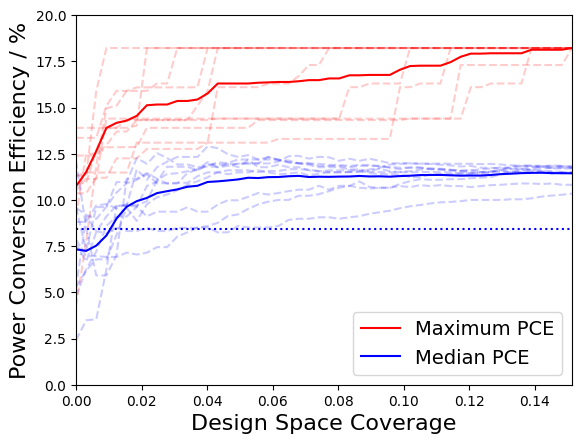

In [168]:
for i_repeat in range(n_repeats):
    coverage = np.arange(50)*batch_size/1295
    plt.plot(coverage,maxpces[i_repeat],c='r',alpha=0.2,linestyle='--')
    plt.plot(coverage,median_pces[i_repeat],c='b',alpha=0.2,linestyle='--')

    
plt.plot(coverage,np.mean(np.array(maxpces),axis=0),c='r',label='Maximum PCE')
plt.plot(coverage,np.mean(np.array(median_pces),axis=0),c='b',label='Median PCE')

plt.axhline(8.4,color='b',linestyle=':')

plt.xlim([0.0,np.max(coverage)])
plt.ylim([0,20])

plt.xlabel('Design Space Coverage',fontsize=16)
plt.ylabel('Power Conversion Efficiency / %',fontsize=16)

plt.legend(fontsize=14)


You can see that the active discovery workflow is very good at increasing the maximum PCE. After sampling just 10% of the design space most of the runs discover the best candidate which has around 18.5% ef